# Sample-Based Krylov Quantum Diagonalization (SKQD)

**Sample-Based Krylov Quantum Diagonalization (SKQD)** is a hybrid quantum-classical algorithm that combines the theoretical guarantees of Krylov Quantum Diagonalization (KQD) with the practical efficiency of sample-based methods. Instead of expensive quantum measurements to compute Hamiltonian matrix elements, SKQD samples from quantum states to construct a computational subspace, then diagonalizes the Hamiltonian within that subspace classically.

## Why SKQD?

Traditional quantum algorithms like VQE face several fundamental challenges:

- **Optimization complexity**: VQE requires optimizing many variational parameters in a high-dimensional, non-convex landscape
- **Measurement overhead**: Computing expectation values $\langle\psi(\theta)|H|\psi(\theta)\rangle$ requires many measurements for each Pauli term
- **Barren plateaus**: Optimization landscapes can become exponentially flat, making gradient-based optimization ineffective
- **Parameter initialization**: Poor initial parameters can lead to local minima far from the global optimum

SKQD addresses these fundamental limitations:

- ✅ **No optimization required**: Uses deterministic quantum time evolution instead of variational circuits
- ✅ **Provable convergence**: Theoretical guarantees based on the Rayleigh-Ritz variational principle
- ✅ **Measurement efficient**: Only requires computational basis measurements (Z-basis), the most natural measurement on quantum hardware  
- ✅ **Noise resilient**: Can filter out problematic measurement outcomes and handle finite sampling
- ✅ **Systematic improvement**: Increasing Krylov dimension monotonically improves ground state estimates
- ✅ **Hardware friendly**: Time evolution circuits are more amenable to near-term quantum devices than deep variational ansätze





## Understanding Krylov Subspaces

### What is a Krylov Subspace?

A **Krylov subspace** $\mathcal{K}^r$ of dimension $r$ is the space spanned by vectors obtained by repeatedly applying an operator $A$ to a reference vector $|\psi\rangle$:

$$\mathcal{K}^r = \text{span}\{|\psi\rangle, A|\psi\rangle, A^2|\psi\rangle, \ldots, A^{r-1}|\psi\rangle\}$$



### The SKQD Algorithm

The key insight of SKQD is that we can:
1. **Generate** Krylov states $U^k|\psi\rangle$ using quantum time evolution
2. **Sample** from these states to get computational basis measurements
3. **Combine** all samples to form a computational subspace
4. **Diagonalize** the Hamiltonian within this subspace classically

This approach is much more efficient than computing matrix elements via quantum measurements!


In [1]:
import cudaq
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
from skqd_src.pre_and_postprocessing import *

use_gpu = True #this is for postprocessing, the quantum circuit simulation is done on GPU via the nvidia target using CUDA-Q
if use_gpu == True:
    from cupyx.scipy.sparse import csr_matrix
    from cupyx.scipy.sparse.linalg import eigsh
else:       
    from scipy.sparse import csr_matrix
    from scipy.sparse.linalg import eigsh


cudaq.set_target('nvidia') 
cudaq.set_random_seed(42)
np.random.seed(43)
cp.random.seed(44)


## Problem Setup: 22-Qubit Heisenberg Model

We'll demonstrate SKQD on a 1D Heisenberg spin chain with 22 qubits:

$$H = \sum_{i} \left(J_x \sigma_i^x \sigma_{i+1}^x + J_y \sigma_i^y \sigma_{i+1}^y + J_z \sigma_i^z \sigma_{i+1}^z\right) + \sum_i \left(h_x \sigma_i^x + h_y \sigma_i^y + h_z \sigma_i^z\right)$$


In [2]:
num_spins = 22 

if num_spins >= 63:
    raise ValueError(f"Vectorized implementation of postprocessing supports max 62 qubits due to int64 packing. Requested: {num_spins}")

shots = 100_000  

total_time_evolution = np.pi  
num_trotter_steps = 8  
dt = total_time_evolution / num_trotter_steps  

max_k = 12  # largest k for U^k

eigenvalue_solver_options = {"k": 2, "which": "SA"}  # Find 2 smallest eigenvalues



Jx, Jy, Jz = 1.0, 1.0, 1.0 
h_x, h_y, h_z = np.ones(num_spins), np.ones(num_spins), np.ones(num_spins)
H = create_heisenberg_hamiltonian(num_spins, Jx, Jy, Jz, h_x, h_y, h_z)
exact_ground_state_energy = -38.272304 # Computed via exact diagonalization
hamiltonian_coefficients, pauli_words = extract_coeffs_and_paulis(H)
hamiltonian_coefficients_numpy = np.array(hamiltonian_coefficients)

## Krylov State Generation via Repeated Evolution

For SKQD, we generate the Krylov sequence:
$$|\psi_0\rangle,  U|\psi_0\rangle,  U^2|\psi_0\rangle, \ldots,  U^{k-1}|\psi_0\rangle$$

where $U = e^{-iHT}$ is approximated via Trotter decomposition.

**Implementation Strategy**:
1. Start with reference state $|\psi_0\rangle$
2. Apply Trotter-decomposed time evolution $k$ times for $U^k|\psi_0\rangle$
3. Measure each Krylov state in computational basis
4. Accumulate measurement statistics across all Krylov powers



In [3]:
@cudaq.kernel
def quantum_krylov_evolution_circuit(
        num_qubits: int, 
        krylov_power: int, 
        trotter_steps: int,
        dt: float,
        H_pauli_words: list[cudaq.pauli_word],
        H_coeffs: list[float]):
    
    """
    Generate Krylov states via repeated time evolution.
    
    Args:
        num_qubits: Number of qubits in the system
        krylov_power: Power k for computing U^k|ψ⟩
        trotter_steps: Number of Trotter steps for each U application
        dt: Time step for Trotter decomposition
        H_pauli_words: Pauli decomposition of Hamiltonian
        H_coeffs: Coefficients for each Pauli term
    
    Returns:
        Measurement results in computational basis
    """
    
    qubits = cudaq.qvector(num_qubits)

    #Prepare Néel state as reference |010101...⟩
    for qubit_index in range(num_qubits):
        if qubit_index % 2 == 0:
            x(qubits[qubit_index])


    for _ in range(krylov_power):                                            #applies U^k where U = exp(-iHT)
        
        for _ in range(trotter_steps):                                       #applies exp(-iHT)
            
            for i in range(len(H_coeffs)):                                   #applies exp(-iHdt)
                exp_pauli( -1 * H_coeffs[i] * dt, qubits, H_pauli_words[i])  #applies exp(-ihdt)


    mz(qubits)

## Quantum Measurements and Sampling


### The Sampling Process

For each krylov power $ = 0, 1, 2, \ldots, k-1$:
1. **Prepare** the state $U^k|\psi\rangle$ using our quantum circuit
2. **Measure** in the computational basis many times
3. **Collect** the resulting bitstring counts

The key insight: these measurement outcomes give us a statistical representation of each Krylov state, which we can then use to construct our computational subspace classically.


In [4]:
all_measurement_results = []

for krylov_power in range(max_k):
    print(f"Generating Krylov state U^{krylov_power}...")
    
    sampling_result = cudaq.sample(
        quantum_krylov_evolution_circuit,
        num_spins,  
        krylov_power, 
        num_trotter_steps,  
        dt,  
        pauli_words,  
        hamiltonian_coefficients, 
        shots_count=shots) 
        
    all_measurement_results.append(dict(sampling_result.items()))
    

cumulative_results = calculate_cumulative_results(all_measurement_results)


Generating Krylov state U^0...
Generating Krylov state U^1...
Generating Krylov state U^2...
Generating Krylov state U^3...
Generating Krylov state U^4...
Generating Krylov state U^5...
Generating Krylov state U^6...
Generating Krylov state U^7...
Generating Krylov state U^8...
Generating Krylov state U^9...
Generating Krylov state U^10...
Generating Krylov state U^11...


## Classical Post-Processing and Diagonalization

Now comes the classical part of SKQD: we use our quantum measurement data to construct and diagonalize the Hamiltonian within each Krylov subspace.

1. **Extract basis states** from measurement counts
2. **Project Hamiltonian** onto the computational subspace spanned by these states  
3. **Diagonalize** the projected Hamiltonian classically
4. **Extract ground state energy** estimate



### The SKQD Algorithm: Matrix Construction Details

The core of SKQD is constructing the effective Hamiltonian matrix within the computational subspace:

1. **Computational Subspace Formation**: From quantum measurements, we obtain a set of computational basis states $\{|s_1\rangle, |s_2\rangle, \ldots, |s_d\rangle\}$ that spans our approximation to the Krylov subspace.

2. **Matrix Element Computation**: For each Pauli term $P_k$ in the Hamiltonian with coefficient $h_k$:
   $$H = \sum_k h_k P_k$$
   
   We compute matrix elements: $\langle s_i | P_k | s_j \rangle$ by applying the Pauli string $P_k$ to each basis state $|s_j\rangle$.

3. **Effective Hamiltonian**: The projected Hamiltonian becomes:
   $$H_{\text{eff}}[i,j] = \sum_k h_k \langle s_i | P_k | s_j \rangle$$



In [5]:
energies = []

for k in range(1, max_k):

    cumulative_subspace_results = cumulative_results[k]
    basis_states = get_basis_states_as_array(cumulative_subspace_results, num_spins)
    subspace_dimension = len(cumulative_subspace_results)
    assert len(cumulative_subspace_results) == basis_states.shape[0]

    # matrix_rows, matrix_cols, matrix_elements = projected_hamiltonian(basis_states, pauli_words, hamiltonian_coefficients_numpy, verbose) #slower non-vectorized implementation

    #if use_gpu is True, the projected hamiltonian & eigenvalue solver are computed on the GPU
    matrix_rows, matrix_cols, matrix_elements = vectorized_projected_hamiltonian(basis_states, pauli_words, hamiltonian_coefficients_numpy, use_gpu)
    projected_hamiltonian = csr_matrix((matrix_elements, (matrix_rows, matrix_cols)), shape=(subspace_dimension, subspace_dimension))
    eigenvalue = eigsh(projected_hamiltonian, return_eigenvectors=False, **eigenvalue_solver_options)
  
    energies.append(np.min(eigenvalue).item())


## Results Analysis and Convergence

Let's visualize our results and analyze how SKQD converges to the true ground state energy. This is the moment of truth - does our quantum-classical hybrid algorithm work?

### What to Expect:

- **Monotonic improvement**: Each additional Krylov dimension should give a better (lower) energy estimate
- **Convergence**: The estimates should approach the exact ground state energy  
- **Diminishing returns**: Later Krylov dimensions provide smaller improvements

The exact ground state energy for our selected Hamiltonian was computed earlier via classical exact diagonalization and will be used as the reference for comparison with SKQD results.


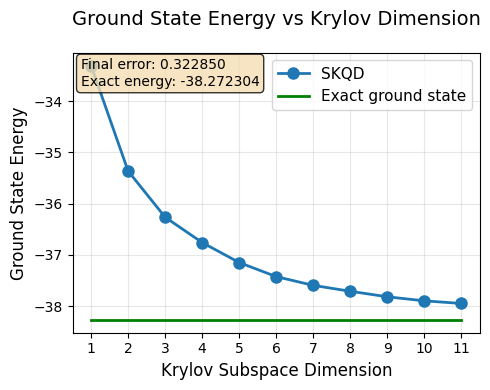

In [6]:
# Create visualization of SKQD convergence

plt.figure(figsize=(5, 4))
all_dims = range(1, max_k)

plt.plot(all_dims, energies, 'o-', linewidth=2, markersize=8, label='SKQD')
plt.plot(all_dims, [exact_ground_state_energy] * (max_k-1), 'g', linewidth=2, label='Exact ground state')

plt.xticks(all_dims)
plt.xlabel("Krylov Subspace Dimension", fontsize=12)
plt.ylabel("Ground State Energy", fontsize=12)
plt.title("Ground State Energy vs Krylov Dimension", fontsize=14, pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

final_error = abs(energies[-1] - exact_ground_state_energy)
plt.text(0.02, 0.98, f'Final error: {final_error:.6f}\nExact energy: {exact_ground_state_energy:.6f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.tight_layout()

plt.show()

## GPU Acceleration for Postprocessing 

The critical postprocessing operations are:

1. Hamiltonian projection onto computational subspace

`matrix_rows, matrix_cols, matrix_elements = vectorized_projected_hamiltonian(basis_states, pauli_words, hamiltonian_coefficients_numpy, use_gpu)`

2. Sparse matrix construction

`projected_hamiltonian = csr_matrix((matrix_elements, (matrix_rows, matrix_cols)), shape=(subspace_dimension, subspace_dimension))`

3. Eigenvalue computation

`eigenvalue = eigsh(projected_hamiltonian, return_eigenvectors=False, **eigenvalue_solver_options)`

This substantial acceleration comes from:
- **Parallel Pauli string evaluation** across thousands of basis states simultaneously
- **Vectorized matrix element computation** leveraging CUDA cores
- **GPU-optimized sparse linear algebra** via cuSPARSE library for eigenvalue solving

The speedup becomes increasingly critical as the Krylov dimension grows, since the computational subspace dimension (and thus the matrix size) scales exponentially with k. For higher k values, GPU acceleration transforms previously intractable postprocessing into feasible computation times.

**Note**: Set `use_gpu = True` at the beginning of the notebook to enable GPU acceleration for postprocessing. The quantum circuit simulation uses the NVIDIA target in CUDA-Q regardless of this flag.

The data in the plot below was gathered by averaging over 5 runs on a NVIDIA H100 GPU and an Intel Xeon Platinum 8480CL CPU with 224 threads. The only thing that changed between the 2 data points was `use_gpu = True` and `use_gpu = False`.


<img src="images/speedup.png" width="600">

In [7]:
print("Using:", cudaq.__version__)

Using: CUDA-Q Version  (https://github.com/NVIDIA/cuda-quantum 37053302ceb3d83684186b2a99aac500df7b847e)
